In [27]:
import cv2
import imageio
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle
from random import randint

In [8]:
# Video capture source camera
cap = cv2.VideoCapture(0) 
data_list = []
start_recording = False

while(True):
    ret, frame = cap.read()
    grey = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(grey, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)/255
    key_pressed =  str(chr(cv2.waitKey(5) & 0xFF))

    cv2.putText(grey, str(len(data_list)), (10,50), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 2, cv2.LINE_AA)
    cv2.imshow('frame', grey)

    if key_pressed == 'r':
        start_recording = True
    
    if start_recording == True:
        data_list.append(img)
    
    if len(data_list) == 1000 or key_pressed == 'e':
        cap.release()
        cv2.destroyAllWindows()
        break

In [9]:
# Save current capture to disk
current_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
with open(f'cam_data_{len(data_list)}_samples_{current_time}', 'wb') as fp:
    pickle.dump(data_list, fp)

In [10]:
# load the data
with open ('cam_data_1000_samples_2019-01-03_15-46-51', 'rb') as fp:
    data_switch = pickle.load(fp)
with open ('cam_data_1000_samples_2019-01-03_15-47-54', 'rb') as fp:
    data_ps4 = pickle.load(fp)
with open ('cam_data_1000_samples_2019-01-03_15-48-40', 'rb') as fp:
    data_vuoto= pickle.load(fp)

In [12]:
# Prepare labels
y_np_switch = np.zeros(len(data_switch)) + 0
y_np_ps4    = np.zeros(len(data_ps4)) + 1
y_np_vuoto  = np.zeros(len(data_vuoto)) + 2

In [16]:
# Prepare data
x_np_switch = np.array(data_switch)
x_np_ps4 = np.array(data_ps4)
x_np_vuoto = np.array(data_vuoto)

In [25]:
# Join and split into test/training
X = np.vstack([x_np_switch, x_np_ps4, x_np_vuoto])
y = np.hstack([y_np_switch, y_np_ps4, y_np_vuoto])

In [45]:
X_ = X.reshape(X.shape[0], 100, 100, 1)

In [66]:
# Image preprocessing
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=.2,
    height_shift_range=.2,
    horizontal_flip=True)

datagen.fit(X_)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_,np.array(pd.get_dummies(y)), test_size=.1)

In [68]:
X_train.shape

(2700, 100, 100, 1)

In [69]:
n_categories = np.array(pd.get_dummies(y)).shape[1]

[0 0 1]


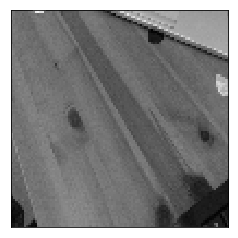

In [70]:
# Show picture / label
plt.xticks([]), plt.yticks([])
idx = randint(0,X_train.shape[0])
plt.imshow(X_train[idx].reshape(100,100), cmap='gray')
print(y_train[idx])

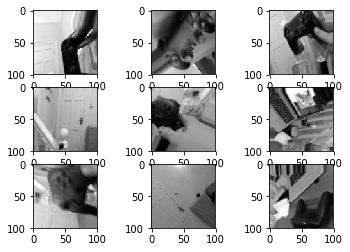

In [81]:
# Retrieve one batch of images for testing
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(100, 100), cmap='gray')
    # show the plot
    plt.show()
    break

In [64]:
X_train.shape

(2700, 100, 100, 1)

In [84]:
# Convolutional NN
model = keras.models.Sequential()

layers = [
    
    # Block 1
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format ='channels_last', input_shape=(100, 100, 1)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),

    # Block 2
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),

    # Block 3
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),
 
    # Classification block
    keras.layers.Flatten(name='flatten'),
    keras.layers.Dense(4096, activation='relu', name='fc1'),
    keras.layers.Dense(4096, activation='relu', name='fc2'),
    keras.layers.Dense(n_categories, activation='softmax', name='predictions')
    ]
for layer in layers:
    model.add(layer)

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) / 32, epochs=9, validation_data=(X_test, y_test))
model.summary()

Epoch 1/3
85/84 [==============================] - 950s 11s/step - loss: 1.0776 - acc: 0.3928 - val_loss: 1.1677 - val_acc: 0.3533
Epoch 2/3
85/84 [==============================] - 1075s 13s/step - loss: 0.7983 - acc: 0.6179 - val_loss: 1.2108 - val_acc: 0.3667
Epoch 3/3


KeyboardInterrupt: 

In [85]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [37]:
model.evaluate(X_test, y_test)

300/300 [==============================] - 2s 7ms/step


[0.018124361398319404, 0.9966666666666667]

[0 1 0] 2 [[0.256717   0.20482512 0.5384579 ]]


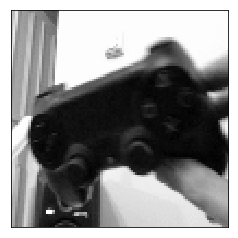

In [88]:
plt.xticks([]), plt.yticks([])
idx = randint(0,X_test.shape[0])
plt.imshow(X_test[idx].reshape(100,100), cmap='gray')
prediction = model.predict(X_test[idx].reshape(1, 100, 100, 1))
print(y_test[idx], np.argmax(prediction), prediction)

In [48]:
# Load trained model (this comes from google Colab)


(100, 100)

In [90]:
cap = cv2.VideoCapture(0) # video capture source camera (Here webcam of laptop) 
labels = ['switch', 'ps4', 'vuoto']

while(True):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    key_pressed =  str(chr(cv2.waitKey(5) & 0xFF))
    
    img = cv2.resize(gray, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
    np_img = np.array(img)/255
    prediction = model.predict(np_img.reshape(1, 100, 100, 1))
    prediction_perc = ['{:.1%}'.format(perc) for perc in prediction[0]]
    
    # display the captured image
    cv2.putText(frame, f'{labels[np.argmax(prediction)]} {prediction_perc}', (10,50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.imshow('frame', frame)

    if key_pressed == 'e': # close by pressing 'e' 
        cap.release()
        cv2.destroyAllWindows()
        break

In [15]:
(np_img/255).shape

(100, 100)

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 100, 100, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 25, 25, 256)       295168    
__________